# Showcases integrated gradients on CIFAR10 dataset

This tutorial demonstrates how to apply model interpretability algorithms from Captum library on a simple model and test samples from CIFAR dataset.

In this tutorial we build a simple model as described in:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

Then we use attribution algorithms such as `IntegratedGradients`, `Saliency`, `DeepLift` and `NoiseTunnel` to attribute the label of the image to the input pixels and visualize it.
  
  **Note:** Before running this tutorial, please install the torchvision, and matplotlib packages.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In the cell below we load test and train datasets, define image transformers and supported classification label classes.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = datasets.CIFAR10(
    root="./assets/datasets/CIFAR10", train=True, download=True, transform=transform
)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(
    root="./assets/datasets/CIFAR10", train=False, download=True, transform=transform
)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified


We define a classification network based on the architecture proposed in the following tutorial:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Trains `Net` model for a very small number of epochs. The training code snippet is copied from the tutorial mentioned above.
In order to avoid training the model every time from scratch, we save a pretrained version of the model in `models` folder and load it from there. https://github.com/pytorch/captum/blob/master/tutorials/models/cifar_torchvision.pt

---

训练极少数时期的 `Net` 模型。 训练代码片段是从上面提到的教程中复制的。
为了避免每次从头开始训练模型，我们将模型的预训练版本保存在 `models` 文件夹中并从那里加载。 https://github.com/pytorch/captum/blob/master/tutorials/models/cifar_torchvision.pt

In [5]:
USE_PRETRAINED_MODEL = False

if USE_PRETRAINED_MODEL:
    print("Using existing trained model")
    net.load_state_dict(torch.load("models/cifar_torchvision.pt"))
else:
    for epoch in range(5):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print("Finished Training")
    torch.save(net.state_dict(), "./assets/models/cifar_torchvision.pt")

[1,  2000] loss: 2.145
[1,  4000] loss: 1.824
[1,  6000] loss: 1.665
[1,  8000] loss: 1.575
[1, 10000] loss: 1.509
[1, 12000] loss: 1.478
[2,  2000] loss: 1.393
[2,  4000] loss: 1.365
[2,  6000] loss: 1.335
[2,  8000] loss: 1.323
[2, 10000] loss: 1.279
[2, 12000] loss: 1.281
[3,  2000] loss: 1.202
[3,  4000] loss: 1.210
[3,  6000] loss: 1.188
[3,  8000] loss: 1.184
[3, 10000] loss: 1.169
[3, 12000] loss: 1.190
[4,  2000] loss: 1.100
[4,  4000] loss: 1.125
[4,  6000] loss: 1.103
[4,  8000] loss: 1.100
[4, 10000] loss: 1.093
[4, 12000] loss: 1.089
[5,  2000] loss: 1.012
[5,  4000] loss: 1.009
[5,  6000] loss: 1.048
[5,  8000] loss: 1.036
[5, 10000] loss: 1.032
[5, 12000] loss: 1.034
Finished Training


In the cell below we load some images from the test dataset and perform predictions.

In [6]:
def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


images, labels = next(iter(testloader))
images.shape, labels

(torch.Size([4, 3, 32, 32]), tensor([3, 8, 8, 0]))

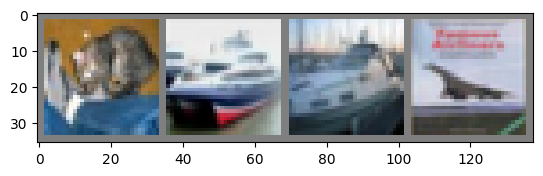

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship truck plane


In [7]:
# 显示图片
imshow(torchvision.utils.make_grid(images))

print("GroundTruth: ", " ".join("%5s" % classes[labels[j]] for j in range(4)))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join("%5s" % classes[predicted[j]] for j in range(4)))

Let's choose a test image at index `index` and apply some of our attribution algorithms on it.

In [8]:
images.shape

torch.Size([4, 3, 32, 32])

In [9]:
# 选择最后一张图片
index = 3

input = images[index].unsqueeze(0)
input.requires_grad = True  # 需要梯度
input.shape

torch.Size([1, 3, 32, 32])

Sets model to eval mode for interpretation purposes

In [10]:
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

A generic function that will be used for calling `attribute` on attribution algorithm defined in input.

In [11]:
print(labels)  # 4张图片的pred_id
print(index)  # 第4张图片
print(labels[index])  # 第4张图片的pred_id

tensor([3, 8, 8, 0])
3
tensor(0)


In [12]:
def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(
        inputs=input, target=labels[index], **kwargs
    )

    return tensor_attributions

## Saliency

Computes gradients with respect to class `index` and transposes them for visualization purposes.

---

计算与 `index` 类相关的梯度并转置它们以实现可视化目的。

In [13]:
saliency = Saliency(net)
saliency

In [15]:
grads = saliency.attribute(inputs=input, target=labels[index].item())
grads.shape

torch.Size([1, 3, 32, 32])

In [16]:
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))
grads.shape

(32, 32, 3)

## IntegratedGradients

Applies integrated gradients attribution algorithm on test image. Integrated Gradients computes the integral of the gradients of the output prediction for the class index `index` with respect to the input image pixels. More details about integrated gradients can be found in the original paper: https://arxiv.org/abs/1703.01365

---

在测试图像上应用集成梯度归因算法。 积分梯度计算类索引 `index` 的输出预测梯度相对于输入图像像素的积分。 有关积分梯度的更多详细信息可以在原始论文中找到：https://arxiv.org/abs/1703.01365

In [17]:
ig = IntegratedGradients(net)
ig

In [18]:
attr_ig, delta = attribute_image_features(
    ig, input, baselines=input * 0, return_convergence_delta=True
)
attr_ig.shape, delta

(torch.Size([1, 3, 32, 32]), tensor([0.0766], dtype=torch.float64))

In [19]:
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print("Approximation delta: ", abs(delta))

Approximation delta:  tensor([0.0766], dtype=torch.float64)


## NoiseTunnel

Below we demonstrate how to use integrated gradients and noise tunnel with smoothgrad square option on the test image. Noise tunnel with `smoothgrad square` option adds gaussian noise with a standard deviation of `stdevs=0.2` to the input image `nt_samples` times, computes the attributions for `nt_samples` images and returns the mean of the squared attributions across `nt_samples` images.

---

下面我们演示如何在测试图像上使用带有 smoothgrad square 选项的集成梯度和噪声隧道。 具有 `smoothgrad square` 选项的噪声隧道将标准偏差为 `stdevs=0.2` 的高斯噪声添加到输入图像 `nt_samples` 次，计算 `nt_samples` 图像的属性并返回 `nt_samples` 的平方属性的平均值 图片。

In [20]:
ig = IntegratedGradients(net)
ig

In [21]:
nt = NoiseTunnel(ig)
nt

In [22]:
attr_ig_nt = attribute_image_features(
    nt, input, baselines=input * 0, nt_type="smoothgrad_sq", nt_samples=100, stdevs=0.2
)
attr_ig_nt.shape

torch.Size([1, 3, 32, 32])

In [23]:
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
attr_ig_nt.shape

(32, 32, 3)

## DeepLift

Applies DeepLift on test image. Deeplift assigns attributions to each input pixel by looking at the differences of output and its reference in terms of the differences of the input from the reference.

---

在测试图像上应用 DeepLift。 Deeplift 通过根据输入与参考的差异查看输出及其参考的差异，为每个输入像素分配属性。

In [24]:
dl = DeepLift(net)
dl

In [25]:
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl.shape

d:\miniconda3\envs\pytorch\Lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


torch.Size([1, 3, 32, 32])

In [26]:
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
attr_dl.shape

(32, 32, 3)

## show gradient

In the cell below we will visualize the attributions for `Saliency Maps`, `DeepLift`, `Integrated Gradients` and `Integrated Gradients with SmoothGrad`.

Original Image
Predicted: plane  Probability: 0.9009672403335571


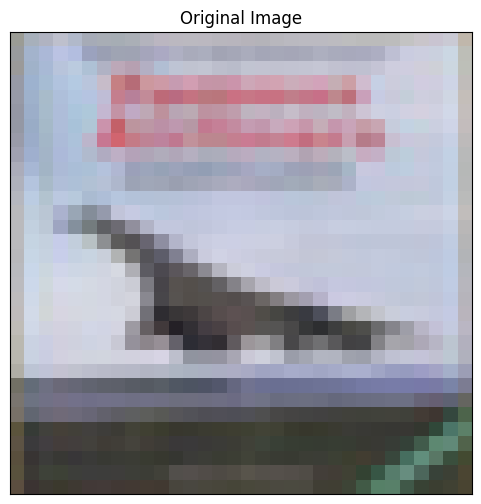

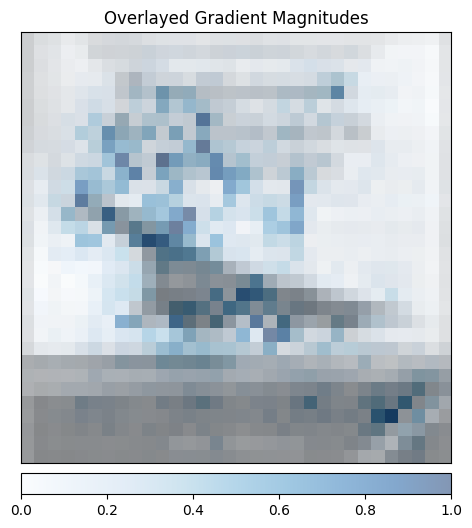

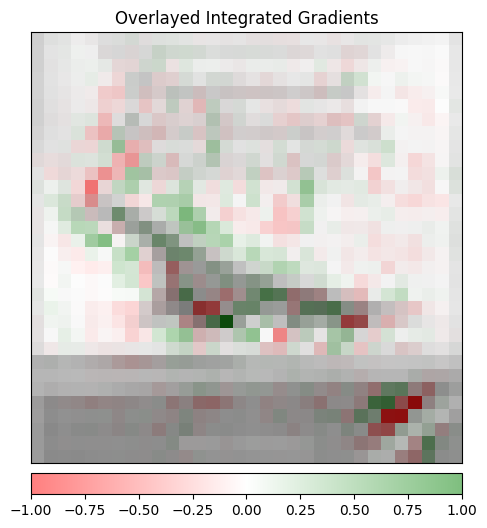

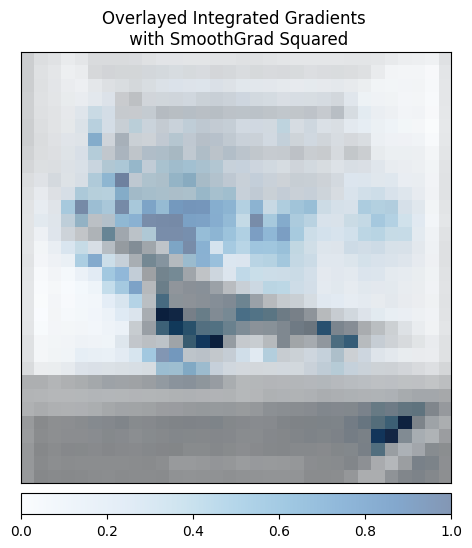

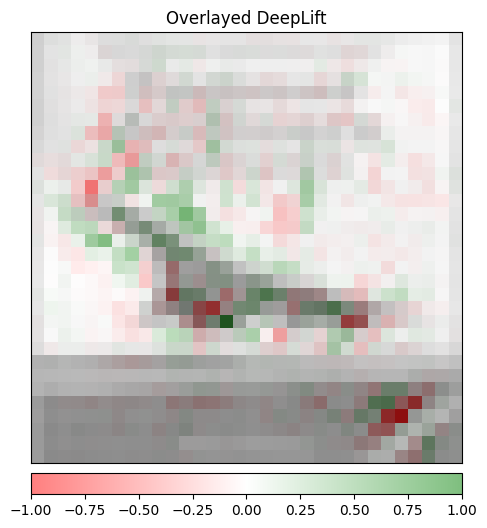

In [27]:
print("Original Image")
print(
    "Predicted:",
    classes[predicted[index]],
    " Probability:",
    torch.max(F.softmax(outputs, 1)).item(),
)

original_image = np.transpose(
    (images[index].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0)
)

_ = viz.visualize_image_attr(
    attr=None,
    original_image=original_image,
    method="original_image",
    title="Original Image",
)

_ = viz.visualize_image_attr(
    attr=grads,
    original_image=original_image,
    method="blended_heat_map",
    sign="absolute_value",
    show_colorbar=True,
    title="Overlayed Gradient Magnitudes",
)

_ = viz.visualize_image_attr(
    attr=attr_ig,
    original_image=original_image,
    method="blended_heat_map",
    sign="all",
    show_colorbar=True,
    title="Overlayed Integrated Gradients",
)

_ = viz.visualize_image_attr(
    attr=attr_ig_nt,
    original_image=original_image,
    method="blended_heat_map",
    sign="absolute_value",
    outlier_perc=10,
    show_colorbar=True,
    title="Overlayed Integrated Gradients \n with SmoothGrad Squared",
)

_ = viz.visualize_image_attr(
    attr=attr_dl,
    original_image=original_image,
    method="blended_heat_map",
    sign="all",
    show_colorbar=True,
    title="Overlayed DeepLift",
)